In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import load_iris

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier  # let several estimators vote
from sklearn.ensemble import BaggingClassifier  # bootstrap aggregation from a single estimator
from sklearn.ensemble import AdaBoostClassifier  # boost weak learners
from sklearn.ensemble import GradientBoostingRegressor  # superimpose all residual error regression trees
from xgboost import XGBRegressor  # faster alternative of sklearn's gbrt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [2]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
# three distinct estimators
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC()

# ensemble all three and get votes
voting_clf = VotingClassifier(estimators=[('lrc', log_clf), ('rfc', rnd_clf), ('svc', svm_clf)], 
                              voting='hard')  # the majority vote wins
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lrc', LogisticRegression()),
                             ('rfc', RandomForestClassifier(random_state=42)),
                             ('svc', SVC())])

In [4]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [5]:
# soft voting (with predict_proba enabled)
svm_clf_with_prob = SVC(probability=True)

# ensemble and soft vote
voting_clf = VotingClassifier(estimators=[('lrc', log_clf), ('rfc', rnd_clf), ('svc', svm_clf_with_prob)], 
                              voting='soft')  # the highest weighted class probability wins

for clf in (log_clf, rnd_clf, svm_clf_with_prob, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


In [6]:
bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),  # similar to RandomForestClassifier()
                            n_estimators=500,  # run the base estimator 500 times 
                            max_samples=100,   
                            bootstrap=True,    # with replacement; False for without replacement
                            random_state=42,
                            n_jobs=-1)         # parallel computing - use all CPU cores
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier 0.904


In [8]:
# use random forest (.feature_importances_) for feature selection
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris['data'], iris['target'])  # fit all features to target classes

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)  # indeed, petal length & width are the most important features

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [10]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                             n_estimators=200, 
                             algorithm='SAMME.R',  # for multiclass AdaBoost
                             learning_rate=0.5)    # how fast the weights ('boost') are added
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print(ada_clf.__class__.__name__, accuracy_score(y_test, y_pred))

AdaBoostClassifier 0.896


In [30]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

# gradient boosted regression trees (GBRT)
gbrt = GradientBoostingRegressor(max_depth=2, 
                                 n_estimators=3,   # 3 superimposes of depth-2 regression trees
                                 learning_rate=1,  # to scale the size of each superimpose
                                 random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, 
                                      n_estimators=200,  # more superimposes, but,
                                      learning_rate=0.1, # each at a smaller increment
                                      random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [34]:
len(gbrt)  # gbrt is a list of residual error regressors

3

In [23]:
len(gbrt_slow)

200

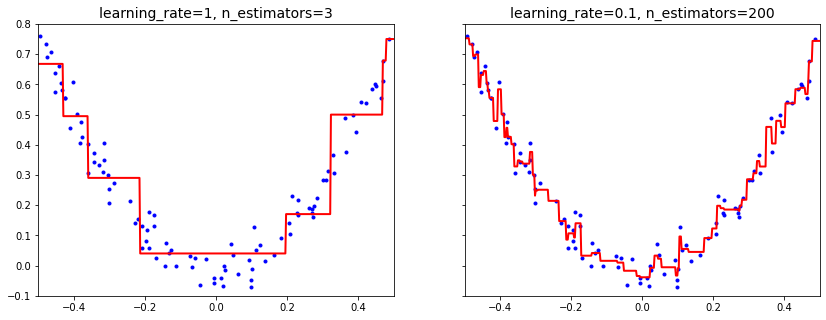

In [38]:
# fast - underfit vs slow - overfit
fig, ax = plt.subplots(ncols=2, figsize=(14,5), sharey=True)
axes=[-0.5, 0.5, -0.1, 0.8]
x1 = np.linspace(axes[0], axes[1], 500)

plt.sca(ax[0])
y_pred = sum(reg.predict(x1.reshape(-1, 1)) for reg in [gbrt])  # superimpose all residual error regressions
plt.plot(X[:, 0], y, 'b.')               # data points
plt.plot(x1, y_pred, 'r-', linewidth=2)  # gbrt predictions
plt.axis(axes)
plt.title("learning_rate=1, n_estimators=3", fontsize=14)

plt.sca(ax[1])
y_pred_slow = sum(reg.predict(x1.reshape(-1, 1)) for reg in [gbrt_slow])
plt.plot(X[:, 0], y, 'b.')
plt.plot(x1, y_pred_slow, 'r-', linewidth=2)
plt.axis(axes)
plt.title("learning_rate=0.1, n_estimators=200", fontsize=14);

In [41]:
# find the optimum n_estimator (number of trees)
X_train, X_test, y_train, y_test = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=200)  # try within 200 trees
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred) 
          for y_pred in gbrt.staged_predict(X_test)]  # staged_predict for 1 tree, 2 trees,..., 200 trees
best_n_estimators = np.argmin(errors) + 1  # n trees with lowest mse

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)  # 56 trees is the best
gbrt_best.fit(X_train, y_train)  

GradientBoostingRegressor(max_depth=2, n_estimators=56)

In [50]:
# alternative python library for gbrt:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_test)

[0]	validation_0-rmse:0.21804
[1]	validation_0-rmse:0.15596
[2]	validation_0-rmse:0.11596
[3]	validation_0-rmse:0.09330
[4]	validation_0-rmse:0.07697
[5]	validation_0-rmse:0.06758
[6]	validation_0-rmse:0.06200
[7]	validation_0-rmse:0.05891
[8]	validation_0-rmse:0.05744
[9]	validation_0-rmse:0.05676
[10]	validation_0-rmse:0.05675
[11]	validation_0-rmse:0.05652
[12]	validation_0-rmse:0.05678
